# Linear Mixed Models (LMMs)

#### Running linear mixed models to investigate the relationship between a predictor and a target over time using synthetic data intended to mimic the vitarenal data

Power calculation (based on repeated measures ANOVA, N=24, 4 time levels, and 2 equal sized groups, with 80% power and 5% alpha) shows that effects at the higher boundary of small effect sizes and the lower boundary of medium sized effects of Cohen’s d=.50-.55 (ƞ2=.07) can be reliably detected. This calculation allows for the planned linear mixed-model within-between interaction analyses, described at par. 8.3. For the analyses of main effects on the main endpoint/primary outcome (decrease over time on both cognitive biases within whole sample) the power with a N=24 sample size is considerably larger. Previous studies from our team among healthy volunteers with fatigue complaints showed similar effect sizes after less intensive single-session CBM (Pieterse & Bode, 2018). As LMM analyses can account for missing values effectively, partial missingness of datapoints is allowed and does not necessarily affect this power calculation.

- N = 24,
- Repeated measures = 4
- Groups = 2

In [1]:
2 * 4 * 24

192

In [2]:
from pymer4 import Lmer, simulate_lmm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import diagnostic_plots
import session_info

In [3]:
session_info.show(write_req_file=False)

In [4]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [5]:
number_observations = 4 # amount of observations per group (i.e. user_id)
number_predictors = 5
number_groups = 30 # amount of groups (i.e. user_id)

df, blups, coefficient = simulate_lmm(num_obs=number_observations,
    num_coef=number_predictors,
    num_grps=number_groups,
    coef_vals=None,
    corrs=None,
    grp_sigmas=0.25,
    mus=0.0,
    sigmas=1.0,
    noise_params=(0, 2),
    family='gaussian',
    seed=69420)

df = (df.assign(m00_name= lambda x: np.tile(["m00", "m03", "m06", "m09"], number_groups))
      .assign(diagnosis = np.repeat([0, 1], int(df.shape[0]/2)))
      .rename(columns={"Group": "user_id"}, inplace=False)
      .assign(user_id=lambda x: x["user_id"].astype(int))
      )

In [6]:
display(df.head()), df.shape

,DV,IV1,IV2,IV3,IV4,IV5,user_id,m00_name,diagnosis
0,1.310004,1.282629,0.041641,0.026445,1.112682,-1.396378,1,m00,0
1,0.348110,-0.384780,0.663529,-1.125871,0.127171,0.029313,1,m03,0
2,-0.901572,-0.012763,0.031757,0.363677,-1.443745,-1.150963,1,m06,0
3,1.684844,-0.719206,0.488108,1.113077,-0.524331,0.438103,1,m09,0
4,0.840559,0.621639,-1.237202,0.283866,1.043195,-0.263725,2,m00,0


(None, (120, 9))

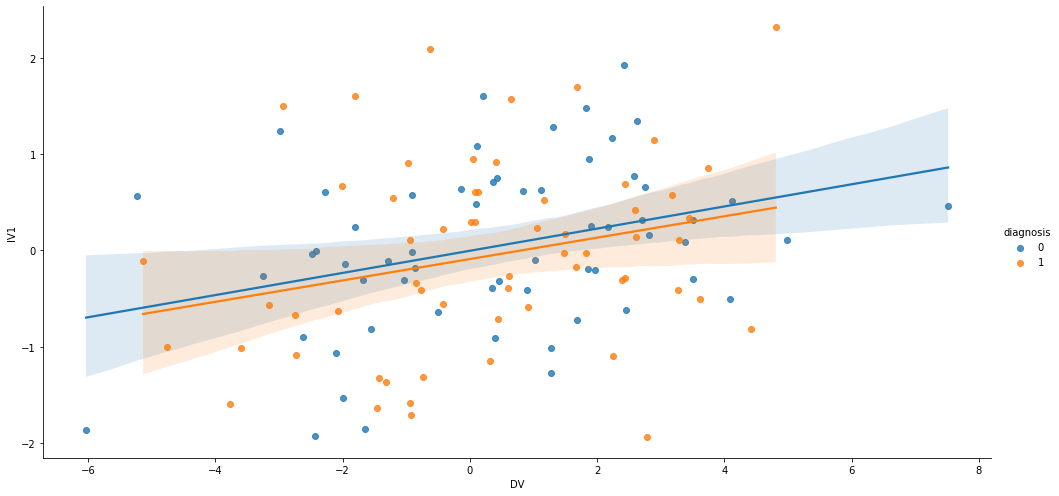

In [7]:
_ = sns.lmplot(data=df, x="DV", y="IV1", hue="diagnosis", height=7, aspect=2)

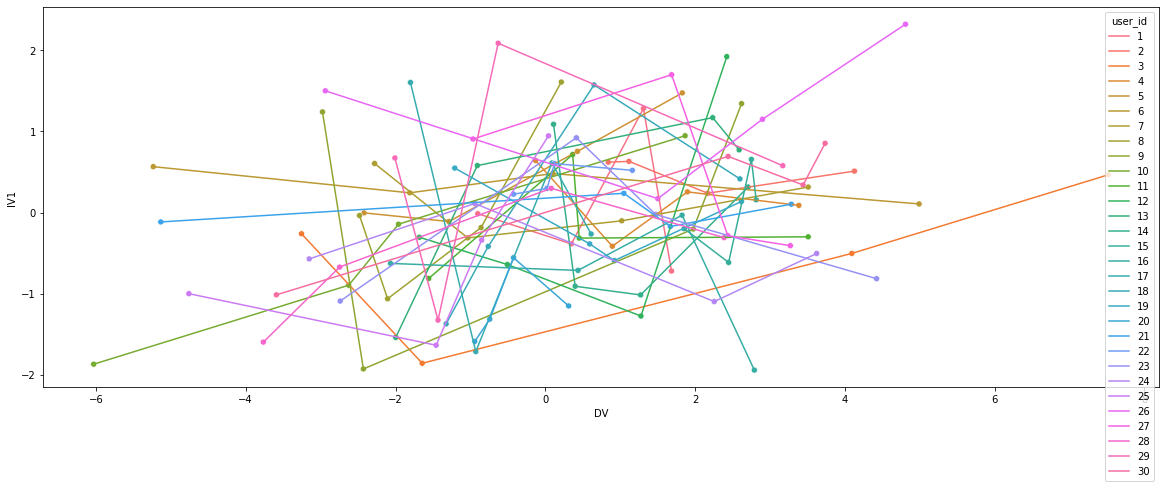

In [8]:
_ = plt.figure(figsize=(20, 7))
_ = sns.lineplot(data=df.assign(user_id=lambda x: x["user_id"].astype("category")), x="DV", y="IV1", hue="user_id")
_ = sns.scatterplot(data=df.assign(user_id=lambda x: x["user_id"].astype("category")), x="DV", y="IV1", hue="user_id", legend=False)

## Specify the predictor list

In [9]:
predictor_list = df.filter(regex="IV").columns.tolist()

# df[predictor_list] = df[predictor_list].mask(np.random.random(df[predictor_list].shape) < .025)

dataLMM = df.dropna()
dataLMM.shape

(120, 9)

In [10]:
feature_collection = " + ".join(predictor_list[-2:4])
feature_collection

'IV4'

## Specify the model with the formula_string as the model syntax

In [11]:
target_name = "DV"

In [12]:
# formula_string = f"{target_name} ~ {feature_collection} + (1 + m00_name|user_id) + (1|diagnosis)"
formula_string = f"{target_name} ~ {feature_collection} + (1|user_id) + (1|m00_name) + (1|diagnosis)"
# formula_string = f"{target_name} ~ {feature_collection} + (1|diagnosis)"
print(formula_string)

model = Lmer(data=dataLMM, formula=formula_string)

DV ~ IV4 + (1|user_id) + (1|m00_name) + (1|diagnosis)


In [13]:
# dataLMM.info()

## Fit the model

Here you can specify factor levels of categorical features, and what approach you want used for confidence intervals of the coefficients

In [14]:
# fixed_effect_output = model.fit(no_warnings=True, conf_int='profile') #model where the m00_name is not considered an ordered categorical feature
fixed_effect_output = model.fit(factors = {"m00_name": dataLMM["m00_name"].unique().tolist()}, 
                                ordered=True, no_warnings=True, conf_int='profile')

fixed_effect_output

Formula: DV~IV4+(1|user_id)+(1|m00_name)+(1|diagnosis)

Family: gaussian	 Inference: parametric

Number of observations: 120	 Groups: {'user_id': 30.0, 'm00_name': 4.0, 'diagnosis': 2.0}

Log-likelihood: -270.541 	 AIC: 541.081

Random effects:

                  Name    Var    Std
user_id    (Intercept)  0.000  0.000
m00_name   (Intercept)  0.000  0.000
diagnosis  (Intercept)  0.000  0.000
Residual                5.295  2.301

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.305,-0.168,0.778,0.211,118.0,1.446,0.151,
IV4,0.720,0.298,1.141,0.215,118.0,3.346,0.001,**


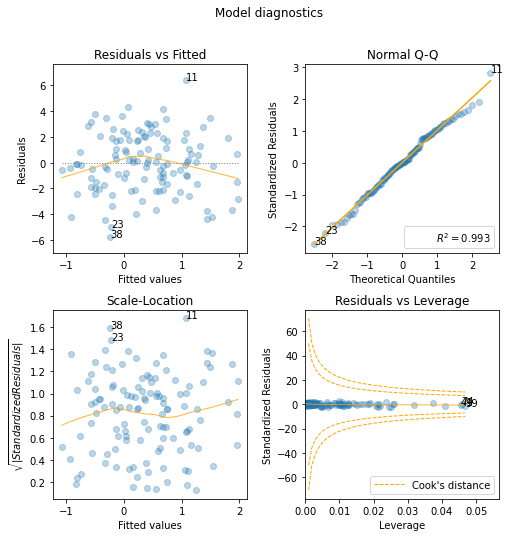

In [15]:
fig, axs = diagnostic_plots(model_fit=model,
                                         X=None,
                                         y=None,
                                         figsize = (8,8),
                                         limit_cooks_plot = False,
                                         subplot_adjust_args={"wspace": 0.3, "hspace": 0.3}
                                        )